# Micrograd Tutorial

Following the video [here](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1)

This file represents the latter portion starting from 1:27:17  

We implement Neuron, Layer, and MLP classes and train the neural network

In [1]:
from micrograd.engine import Value
import random

In [2]:
# Visualization code
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Neuron Backprop with More Atomic Operations

In [3]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add the bias
n = x1w1x2w2 + b
n.label = 'n'

# Output of the nueron is tanh(n), which we are breaking up
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

# backpropagate
o.backward()

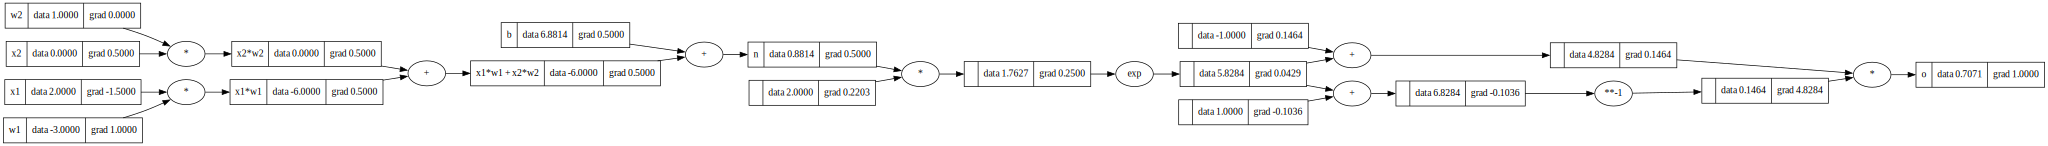

In [4]:
draw_dot(o)

## Comparison to PyTorch

In [5]:
import torch

# Constructing some single-value scalar tensors of type doubel (float64)
# Ensure that PyTorch tracks their gradients with requires_grad=True
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# We need to extract the values by using .item()
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [6]:
# A look at what o is
print(o)

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)


## Neuron Class

In [7]:
class Neuron:

    def __init__(self, num_inputs):
        self.weights = [Value(random.uniform(-1, 1)) for i in range(num_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # z = w * x + b
        z = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        out = z.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]

In [8]:
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))

Value(data=-0.7480920273668734)


## Layer Class

In [9]:
class Layer:

    def __init__(self, num_inputs, num_neurons):
        self.neurons = [Neuron(num_inputs) for i in range(num_neurons)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # equivalent to:
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params

In [10]:
x = [2.0, 3.0]
layer = Layer(2, 3)
layer(x)

[Value(data=0.8818318893250948),
 Value(data=-0.9985595815700621),
 Value(data=0.5039900179554364)]

## MLP Class

In [11]:
class MLP:

    def __init__(self, num_inputs, layer_sizes):
        sz = [num_inputs] + layer_sizes # [num_inputs, layer_sizes[0], layer_sizes[1], ...]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(layer_sizes))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [12]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp_output = mlp(x)
print(mlp_output)

Value(data=0.5815909324341377)


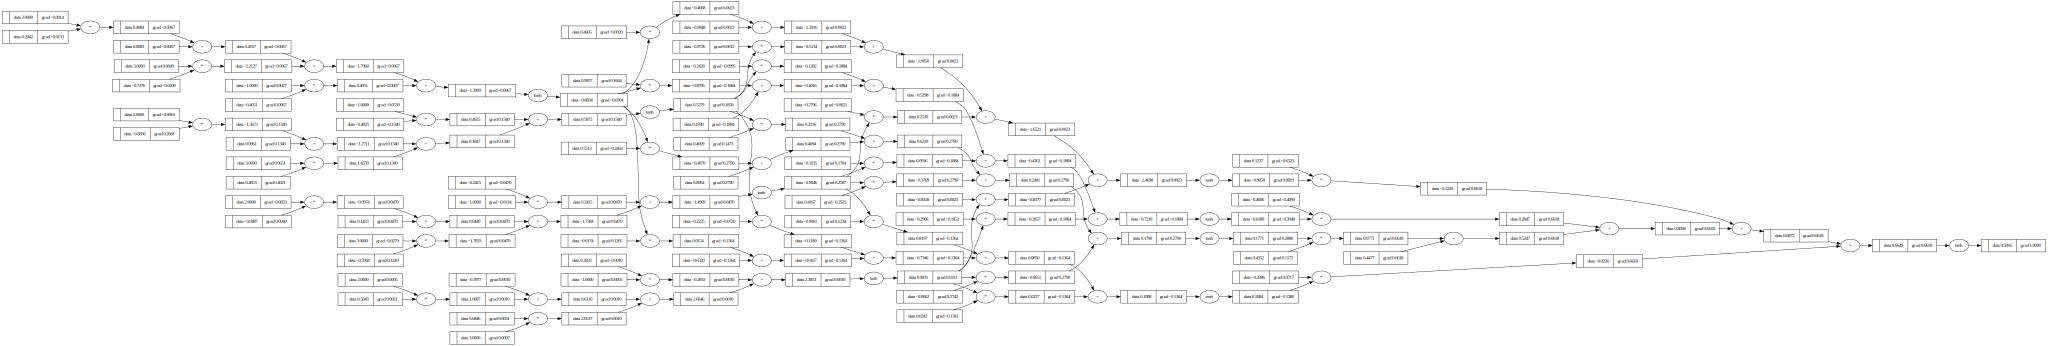

In [13]:
mlp_output.backward()
draw_dot(mlp_output)

## Training

### Simple Dataset to Predict on

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [15]:
# Preliminary predictions - before training
y_preds = [mlp(x) for x in xs]
y_preds

[Value(data=0.5815909324341377),
 Value(data=0.4700737369026691),
 Value(data=0.5008942438926682),
 Value(data=0.5592978085450485)]

### Loss

In [16]:
# Implementing the mean squared error loss

# Check individual losses
losses = [(y_pred - y)**2 for y_pred, y in zip(ys, y_preds)]
losses

[Value(data=0.1750661478213343),
 Value(data=2.161116791930978),
 Value(data=2.252683531350144),
 Value(data=0.1942184215531967)]

In [17]:
loss = sum(losses)
loss

Value(data=4.783084892655653)

In [18]:
# Backprop on the loss
loss.backward()

In [19]:
# Look at a particular gradient - the neuron's contribution to the loss
mlp.layers[0].neurons[0].weights[0].grad

0.18559602442730574

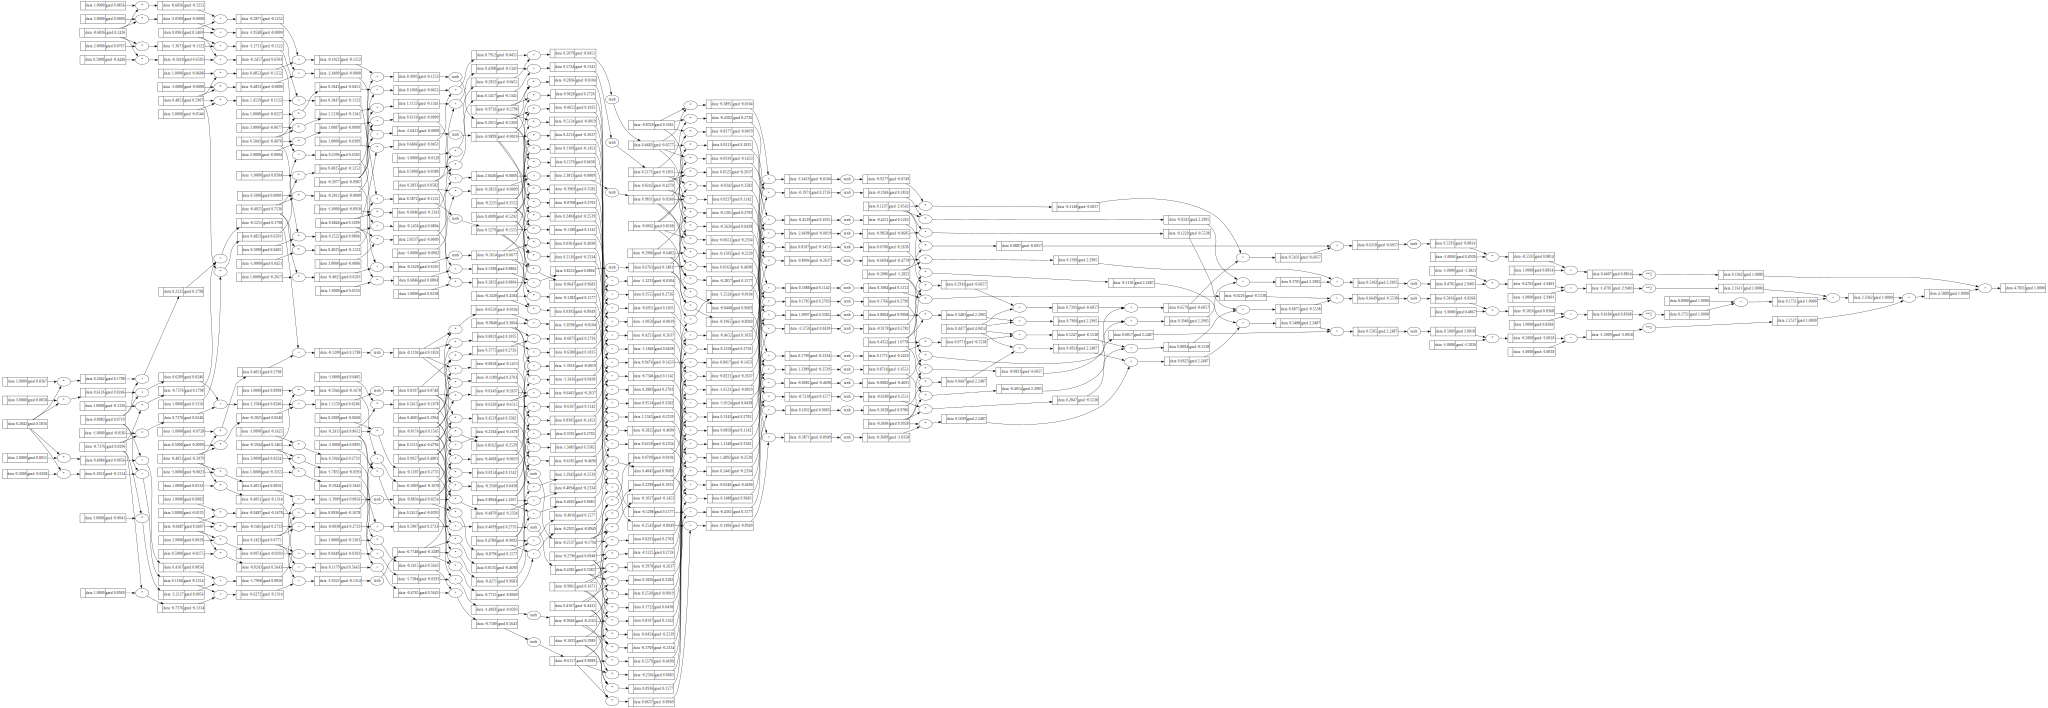

In [20]:
draw_dot(loss)

We can see gradients for the input data, but they are not important to the machine learning task, as the inputs are a given. The gradients for the neurons are very valuable as it lets us know how to adjust their parameters to reduce the network's loss.

## Checking the Parameters

In [21]:
mlp.parameters()

[Value(data=0.20419064520832597),
 Value(data=-0.7375508787862601),
 Value(data=-0.40506332056473915),
 Value(data=0.008290967128600668),
 Value(data=-0.6836326407638791),
 Value(data=0.4852906983098155),
 Value(data=-0.402456564635443),
 Value(data=0.09614182338953414),
 Value(data=-0.048685431358501674),
 Value(data=-0.5944474150274921),
 Value(data=-0.2414923378270235),
 Value(data=0.14227495532501133),
 Value(data=0.5043480305382313),
 Value(data=0.6845584934120692),
 Value(data=0.2833004677492279),
 Value(data=-0.3977294126354347),
 Value(data=0.5513006598370109),
 Value(data=0.4009201959068538),
 Value(data=0.41669839784564844),
 Value(data=-0.06622360064206312),
 Value(data=0.8963660714459245),
 Value(data=0.9957162396719574),
 Value(data=-0.24281659348969042),
 Value(data=-0.10351124996981453),
 Value(data=-0.290577470308671),
 Value(data=0.4779816829431214),
 Value(data=0.4605361942210964),
 Value(data=-0.9726251870219056),
 Value(data=-0.27963279045763145),
 Value(data=-0.831

## Updating the Parameters

In [22]:
# Look at a particular node:
print(mlp.layers[0].neurons[0].weights[0].grad)
print(mlp.layers[0].neurons[0].weights[0].data)

0.18559602442730574
0.20419064520832597


The gradient measures the impact on loss, so we want to adjust the data in the opposite direction to minimize the loss  

A positive gradient means reducing the node's value, and a negative gradient means increasing it  

We use a small step size to make gradual adjustments

In [23]:
# Update the weights

for p in mlp.parameters():
    p.data -= 0.1 * p.grad

In [24]:
# Check the node again
print(mlp.layers[0].neurons[0].weights[0].grad)
print(mlp.layers[0].neurons[0].weights[0].data)

0.18559602442730574
0.1856310427655954


In [25]:
# Compare loss from before and after the update - it should be lower:
print(loss.data)

# Re-calculate the predictions
y_preds = [mlp(x) for x in xs]
loss = sum((y_pred - y)**2 for y_pred, y in zip(ys, y_preds))
print(loss.data)

4.783084892655653
3.742620583531794


We just have to iterate this process: forward pass, backward pass, update...

## Training Loop

In [26]:
# re-initialize the MLP
mlp = MLP(3, [4, 4, 1])

num_steps = 100
learning_rate = 0.05

for k in range(num_steps):
    # Forward Pass
    y_preds = [mlp(x) for x in xs]
    loss = sum((y_pred - y)**2 for y_pred, y in zip(ys, y_preds))
    
    # Backward Pass
    # Start by zeroing the gradients:
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # Update the weights
    for p in mlp.parameters():
        p.data -= learning_rate * p.grad

    print(f'step {k}, loss {loss.data}')

step 0, loss 3.366175005018881
step 1, loss 2.6445559428950913
step 2, loss 2.2466692832007658
step 3, loss 1.8420411471295297
step 4, loss 1.4431904919837863
step 5, loss 1.0965545278798767
step 6, loss 0.8342250586476696
step 7, loss 0.5712320398009808
step 8, loss 0.29041730225100737
step 9, loss 0.174489985077469
step 10, loss 0.1375050925784444
step 11, loss 0.11213196212347143
step 12, loss 0.09386815748133207
step 13, loss 0.08024235156474804
step 14, loss 0.0697688665261189
step 15, loss 0.061514415507572494
step 16, loss 0.05486991114575846
step 17, loss 0.049424262947590974
step 18, loss 0.044891703771692576
step 19, loss 0.04106836620630005
step 20, loss 0.03780545002860239
step 21, loss 0.034992131272471985
step 22, loss 0.032544374974823286
step 23, loss 0.030397430164296364
step 24, loss 0.0285006823243523
step 25, loss 0.026814051397902515
step 26, loss 0.025305425117354632
step 27, loss 0.023948799632392763
step 28, loss 0.02272291208358447
step 29, loss 0.0216102210049

In [27]:
for y_pred, y in zip(y_preds, ys):
    print(f"pred: {y_pred.data}, true: {y}")

pred: 0.9697951800203021, true: 1.0
pred: -0.9773845970489256, true: -1.0
pred: -0.9646632066591699, true: -1.0
pred: 0.9565070940649646, true: 1.0
